In [ ]:
# hide
%reload_ext autoreload
%autoreload 2

In [ ]:
from dataFunction import *
from clientClassDP import *
import diffprivlib.models as dp
import numpy as np
import copy
from make_logreg_data import *
import random
import tensorflow as tf
from FL_utils import *
from typing import Generator
Interval = tuple[Number, Number]

random.seed(11007303)
np.random.seed(2021)

In [638]:
def random_overlapping_intervals(
    n_clients: int,
    total_range: [Interval],
    random_seed: int
    # interval_fraction: [float]
):
    """
    Creates a function that returns random overlapping intervals, with the width
    determined by a fraction of the total interval.
    """
    all_intervals = []
    np.random.seed(random_seed)
    interval_fraction = np.random.rand(n_clients)
    print(interval_fraction)
    for i in range(n_clients):
        interval_list = []
        for j in range(len(total_range)):
            v_min, v_max = total_range[j]
            D = v_max - v_min
            d = D * interval_fraction[i]
            s_start = (np.random.rand() * (D - d)) + v_min
            s_end = s_start + d
            interval_list.append([s_start, s_end])   
        all_intervals.append(interval_list)
    return all_intervals

In [654]:
intervals_per_client = random_overlapping_intervals(10, [[-100, 203], [-103,289], [103, 405], [10, 50], [-19,459], [-183,-96]], 20)
KL_client(intervals_per_client)

[0.5881308  0.89771373 0.89153073 0.81583748 0.03588959 0.69175758
 0.37868094 0.51851095 0.65795147 0.19385022]
54
54
54
54
54
54
54
54
54
54


([-0.3423125892340082,
  -0.34231258923400815,
  -0.34231258923400815,
  -0.3423125892340082,
  -0.3423125892340084,
  -0.34231258923400815,
  -0.34231258923400815,
  -0.34231258923400815,
  -0.34231258923400815,
  -0.3423125892340082],
 [0.3368870250207862,
  0.806777975006291,
  0.799098727401345,
  0.7005156818977386,
  -2.770337658091563,
  0.5172050304583011,
  -0.15228560288083764,
  0.19690009536226594,
  0.46153346289206737,
  -0.8962947370663946])

In [655]:
intervals_per_client2 = random_overlapping_intervals(10, [[-100, 203], [-103,289], [103, 405], [10, 50], [-19,459], [-183,-96]], 30)
KL_client(intervals_per_client2)

[0.64414354 0.38074849 0.66304791 0.16365073 0.96260781 0.34666184
 0.99175099 0.2350579  0.58569427 0.4066901 ]
54
54
54
54
54
54
54
54
54
54


([-0.34231258923400815,
  -0.34231258923400815,
  -0.34231258923400826,
  -0.3423125892340081,
  -0.34231258923400815,
  -0.34231258923400826,
  -0.34231258923400815,
  -0.34231258923400837,
  -0.34231258923400815,
  -0.34231258923400826],
 [0.35738048658458965,
  -0.22682235609463716,
  0.3895201083849192,
  -1.165049675083534,
  0.8037410318427931,
  -0.3310326267204836,
  0.8368810161163128,
  -0.7627192192850895,
  0.25168753546773964,
  -0.1535863012126095])

In [643]:
def KL_divergence(interval_X1, interval_X2):
    max_value1 = max(interval_X1)
    min_value1 = min(interval_X1)

    max_value2 = max(interval_X2)
    min_value2 = min(interval_X2)

    delta_1 = max_value1 - min_value1
    delta_2 = max_value2 - min_value2

    return np.log(delta_1/delta_2)

In [ ]:
def KL_client(intervals_per_client):
    KL_sym_clients = []
    KL_clients = []
    n_features = 6
    for index_1, value_1 in enumerate(intervals_per_client):
        KL_list = []
        sym_KL_list = []
        for index_2, value_2 in enumerate(intervals_per_client):
            if index_1 != index_2:
                for f in range(n_features):
                    kl = KL_divergence(value_1[f], value_2[f])
                    kl2  = KL_divergence(value_2[f], value_1[1])
                    # print(kl, kl2)
                    if kl != 0:
                        sym_kl = (kl+kl2)/2
                    else:
                        sym_kl = 0
                    sym_KL_list.append(sym_kl)
                    KL_list.append(kl)
        # print(index_1)
        print((KL_list))
        KL_sym_clients.append(np.mean(sym_KL_list))
        KL_clients.append(np.mean(KL_list))
    return KL_sym_clients, KL_clients

In [406]:
def create_clients(num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''
    interval = [(-10, 10), (-20,-10), (-40, 50)]
    thresholds = [-30, -40, 10, 20, 23, -90, -18, -93, 39, 0]
    n_samples = 10000
    n_features = 10
    X, y = make_logreg_data(interval, thresholds, n_samples, n_features)
    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = np.concatenate((X, y), axis=1)
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [407]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.1, 
                                                    random_state=42)

In [408]:
client_dict = create_clients(X_train, y_train)

In [415]:
client1_data = pd.DataFrame(client_dict['clients_1'])
client2_data = pd.DataFrame(client_dict['clients_2'])

In [410]:
client1_data.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,-0.061912,0.220896,-0.346974,0.002708,0.377379,0.234453,0.212523,0.007763,-0.145229,0.292300,0.522222
std,5.632380,5.892314,5.808972,5.678284,6.116091,5.884090,5.751539,5.680803,5.587770,5.742885,0.499784
min,-9.971245,-9.980515,-9.928712,-9.948992,-9.942342,-9.945193,-9.986754,-9.968200,-9.854655,-9.995171,0.000000
25%,-4.626235,-5.581971,-5.048275,-4.854360,-5.011996,-4.481090,-4.707728,-4.969208,-5.133312,-4.392090,0.000000
50%,0.122592,0.717697,-0.737544,0.401972,0.900320,0.253938,0.767499,-0.265269,0.020161,0.066468,1.000000
75%,4.534623,5.678096,4.630607,4.309715,6.047284,5.534068,4.988613,4.640540,4.737808,5.678297,1.000000
max,9.899535,9.996833,9.981090,9.995693,9.959880,9.899958,9.999635,9.984352,9.989227,9.952282,1.000000


In [416]:
client2_data.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,0.092517,0.119268,0.006024,0.177072,0.078206,0.163628,0.039771,0.082738,-0.001228,0.008987,0.491111
std,5.709582,5.879483,5.834009,5.848027,5.856453,5.858670,5.738335,5.832617,5.900096,5.740264,0.500199
min,-9.990588,-9.992381,-9.861969,-9.956908,-9.997628,-9.945193,-9.959331,-9.968200,-9.906211,-9.970638,0.000000
25%,-4.834849,-5.123428,-4.961481,-5.058612,-4.997173,-4.997312,-4.853480,-4.984845,-5.133312,-4.764457,0.000000
50%,-0.005245,0.359324,-0.058731,0.513692,0.047444,0.109314,-0.022404,0.231836,-0.051878,-0.049387,0.000000
75%,4.938055,5.207662,5.107675,5.086348,5.354535,5.438277,4.945645,5.050274,5.296507,4.896026,1.000000
max,9.981281,9.991235,9.994304,9.995693,9.972738,9.991883,9.969458,9.977439,9.967592,9.986533,1.000000


In [ ]:
kde = KernelDensity(kernel="tophat", bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

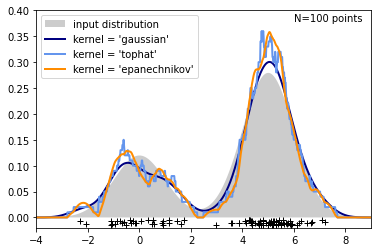

In [414]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
N = 100
np.random.seed(1)
X = np.concatenate(
    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N)))
)[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = 0.3 * norm(0, 1).pdf(X_plot[:, 0]) + 0.7 * norm(5, 1).pdf(X_plot[:, 0])

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")
colors = ["navy", "cornflowerblue", "darkorange"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc="upper left")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

0


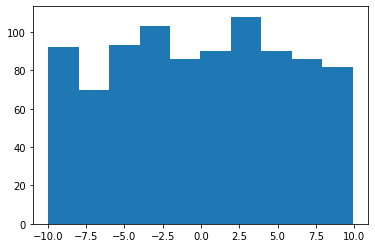

1


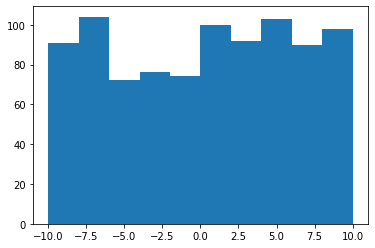

2


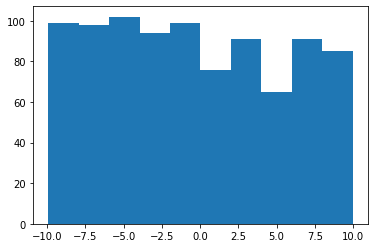

3


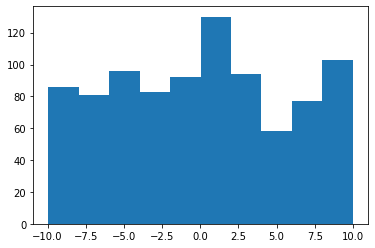

4


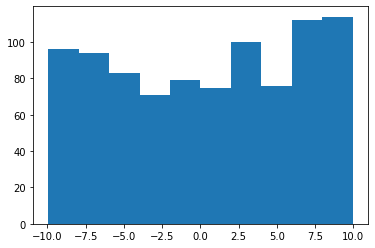

5


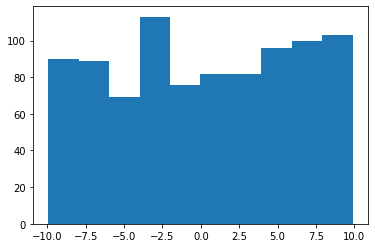

6


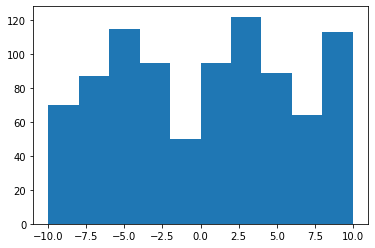

7


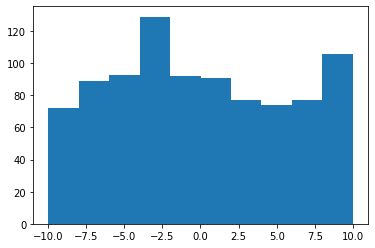

8


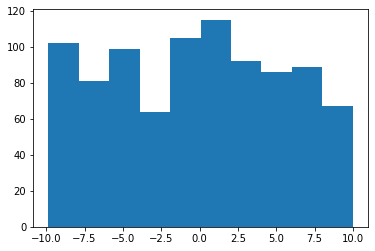

9


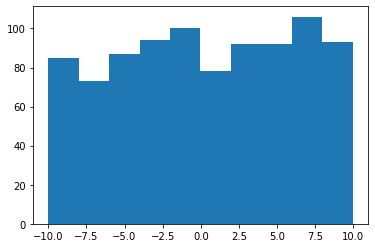

10


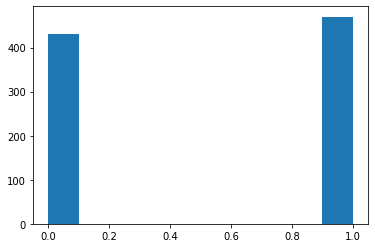

In [411]:
# for i in client1_data.columns:
#     print(i)
#     plt.hist(client1_data[i], bins=10)
#     plt.show()

In [399]:
client1_data.columns

RangeIndex(start=0, stop=11, step=1)